<a href="https://colab.research.google.com/github/amrish1222/DL_pytorch_transfer_learning/blob/master/transfer_learning_AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip3 install torch torchvision

In [0]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [0]:
!git clone https://github.com/jaddoescad/ants_and_bees 

fatal: destination path 'ants_and_bees' already exists and is not an empty directory.


In [0]:
!ls ants_and_bees/

train  val


In [0]:
transforms_train = transforms.Compose([transforms.Resize((224,224)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomRotation(10),
                                       transforms.RandomAffine(0, shear = 10, scale = (0.8,1.2)),
                                       transforms.ColorJitter(brightness = 1, contrast= 1, saturation = 1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5,),(0.5,))
                               ])

transforms = transforms.Compose([transforms.Resize((224,224)),
                                 transforms.ToTensor(),
                               transforms.Normalize((0.5,),(0.5,))
                               ])

training_dataset = datasets.ImageFolder('ants_and_bees/train', transform = transforms_train)
validation_dataset = datasets.ImageFolder('ants_and_bees/val', transform = transforms)

training_loader = torch.utils.data.DataLoader(dataset = training_dataset, batch_size = 20, shuffle = True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 20, shuffle = False)

In [0]:
print(len(training_dataset))
print(len(validation_dataset))

244
153


In [0]:
def im_convert(tensor):
  image = tensor.clone().cpu().detach().numpy()
  image = image.transpose(1,2,0)
  image = image * np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5))
  image = image.clip(0,1)
  return image

In [0]:
classes = ('ant', 'bee')

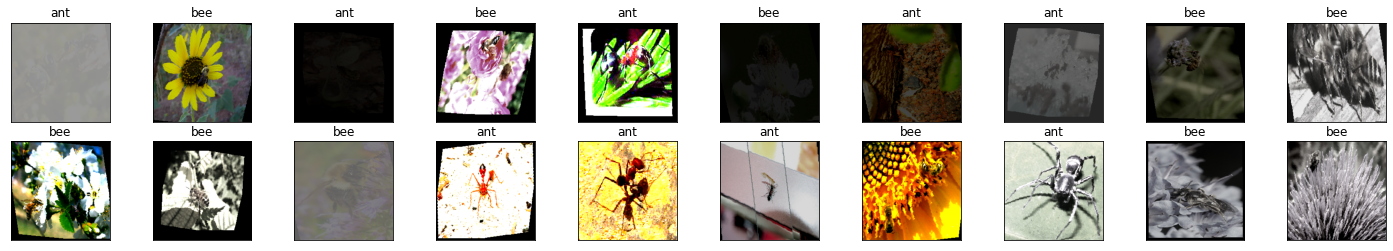

In [0]:
data_iter = iter(training_loader)
images, labels = data_iter.next()
fig = plt.figure(figsize = (25,4))

for idx in np.arange(20):
  ax = fig.add_subplot(2,10,idx+1, xticks = [], yticks = [])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])
  

In [0]:
model = models.alexnet(pretrained = True)

In [0]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [0]:
for param in model.features.parameters():
  param.requires_grad = False

In [0]:
n_inputs = model.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(classes))
model.classifier[6] = last_layer

model.to(device)

print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001)

In [0]:
epochs = 20
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []
 
for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
 
  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = running_loss/len(training_loader.dataset)
    epoch_acc = running_corrects.float()/ len(training_loader.dataset)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader.dataset)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader.dataset)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

epoch : 1
training loss: 0.0358, acc 0.5902 
validation loss: 0.0192, validation acc 0.8627 
epoch : 2
training loss: 0.0242, acc 0.7746 
validation loss: 0.0195, validation acc 0.8431 
epoch : 3
training loss: 0.0273, acc 0.7705 
validation loss: 0.0224, validation acc 0.8235 
epoch : 4
training loss: 0.0215, acc 0.7910 
validation loss: 0.0162, validation acc 0.8824 
epoch : 5
training loss: 0.0238, acc 0.7951 
validation loss: 0.0186, validation acc 0.8824 
epoch : 6
training loss: 0.0209, acc 0.7541 
validation loss: 0.0198, validation acc 0.8627 
epoch : 7
training loss: 0.0200, acc 0.8238 
validation loss: 0.0212, validation acc 0.8562 
epoch : 8
training loss: 0.0174, acc 0.8115 
validation loss: 0.0192, validation acc 0.8889 
epoch : 9
training loss: 0.0163, acc 0.8566 
validation loss: 0.0200, validation acc 0.8889 
epoch : 10
training loss: 0.0184, acc 0.8279 
validation loss: 0.0185, validation acc 0.8889 
epoch : 11
training loss: 0.0184, acc 0.8484 
validation loss: 0.0226

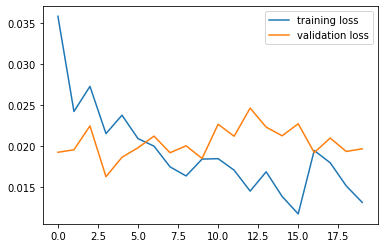

In [0]:
plt.plot(running_loss_history, label = 'training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

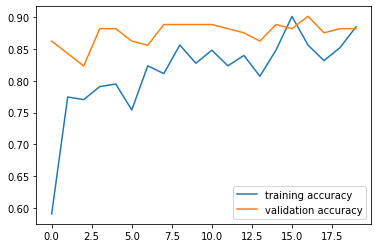

In [0]:
plt.plot(running_corrects_history, label = 'training accuracy')
plt.plot(val_running_corrects_history, label = 'validation accuracy')
plt.legend()

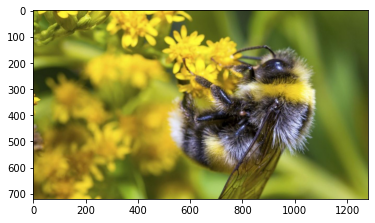

In [0]:
import requests
from PIL import Image
import PIL
url = 'https://cdn.friendsoftheearth.uk/sites/default/files/styles/hero_image/public/bumblebee%20on%20yellow%20flower.jpg?itok=Loe38dm5'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)


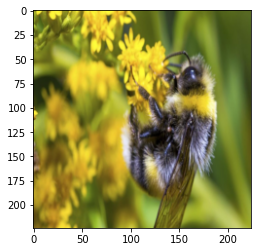

In [0]:
img = transforms(img)
plt.imshow(im_convert(img))

In [0]:
img = img.to(device)
output = model.forward(img.unsqueeze(0))
_,pred = torch.max(output,1)
print(classes[pred.item()])

bee


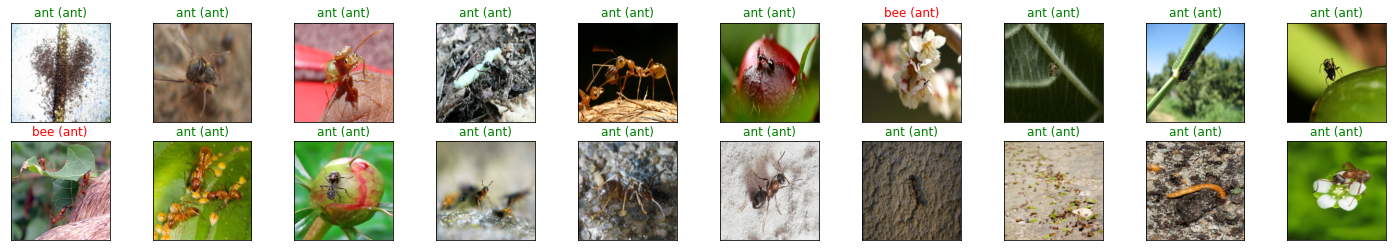

In [0]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)
 
fig = plt.figure(figsize=(25, 4))
 
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))
